# ALY 6110_Final_US_Traffic_Accident

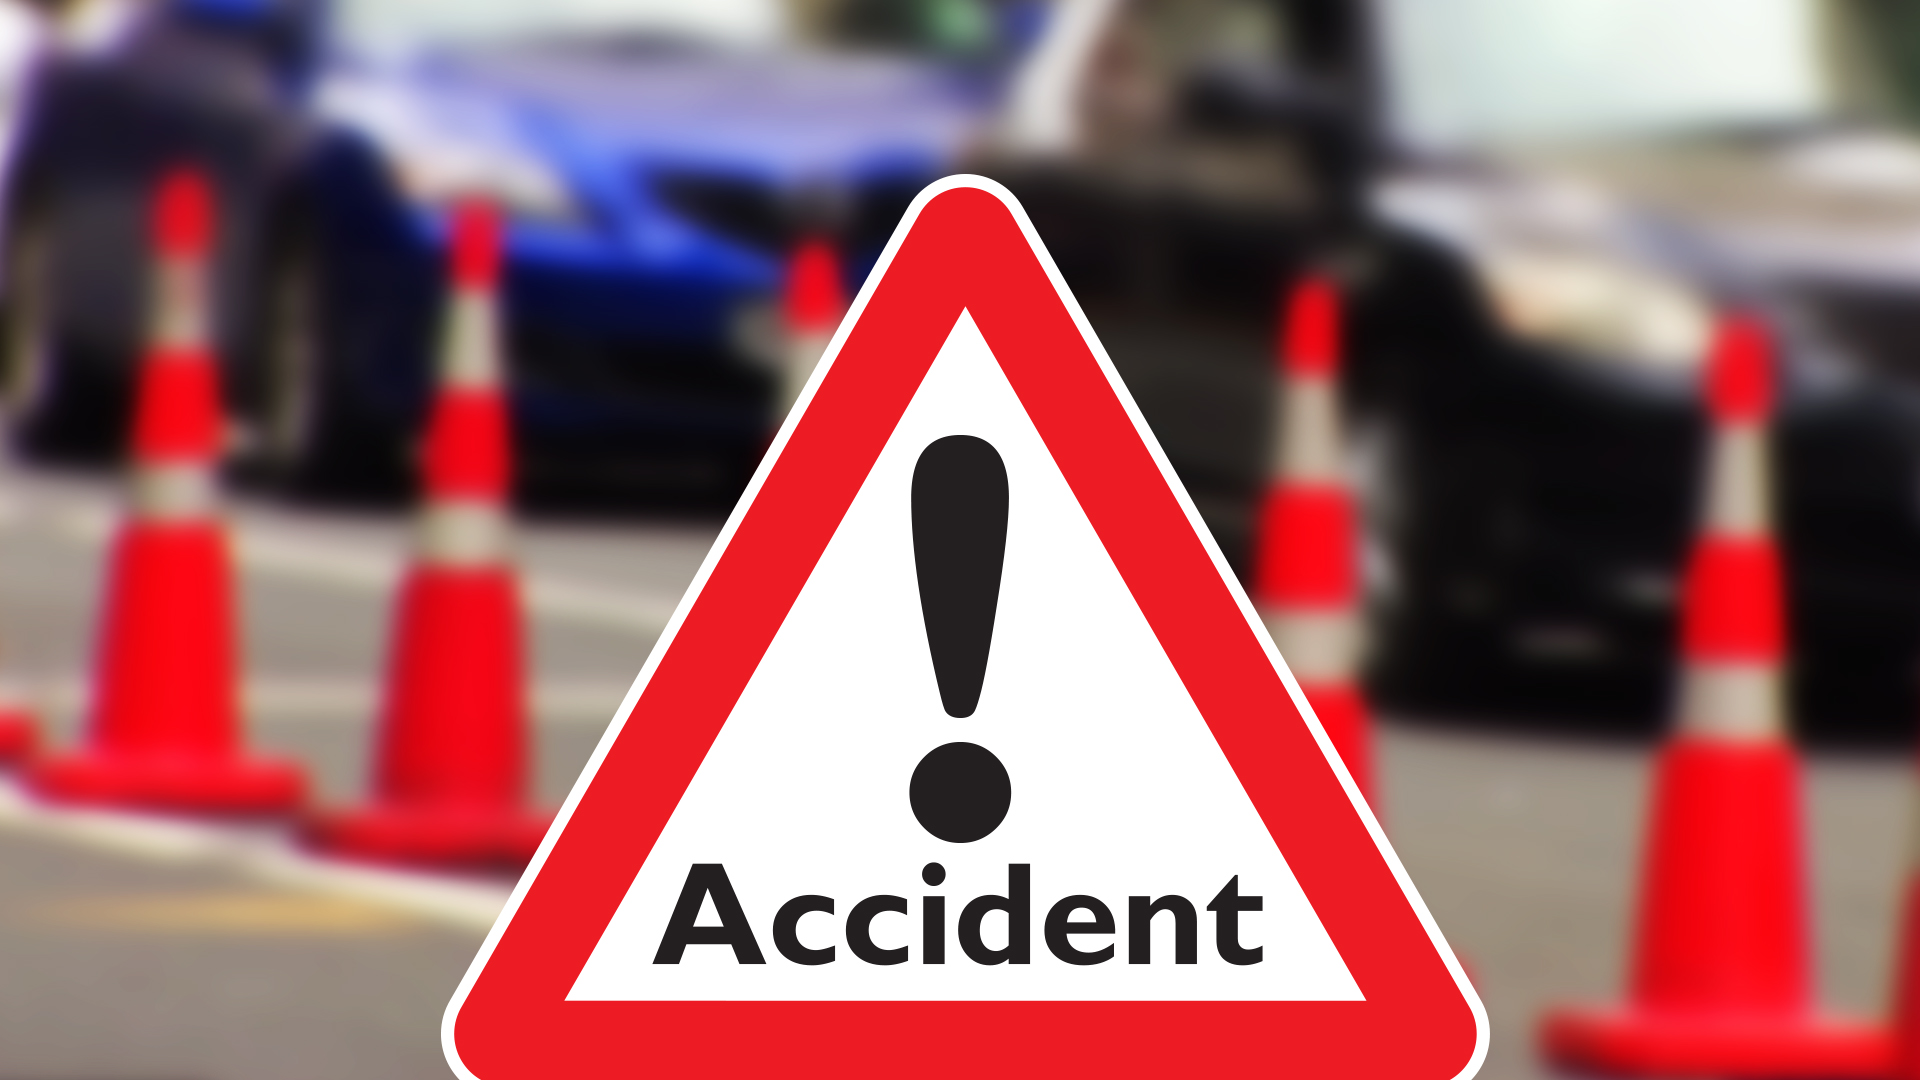

In [345]:
from PIL import Image
Image.open("data-original.jpg")

In [346]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import countDistinct, col, sum, when, coalesce, lit, date_format, to_timestamp, hour, dayofweek
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns

spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [347]:
USaccidentsDf = spark.read.options(header="true",\
                                   inferSchema="true",\
                                   nullValue="NA",\
                                   timestampFormat="yyyy-MM-dd'T'HH:mm:ss",\
                                   mode="failfast")\
                                   .csv("US_Accidents_Dec19.csv")

# A. Data pre-proccessing

In [348]:
USaccidentsDf.count()

2974335

In [349]:
USaccidentsDf.rdd.getNumPartitions()

9

In [350]:
type(USaccidentsDf)

pyspark.sql.dataframe.DataFrame

In [351]:
# Renaming some column names
mapping = dict(zip(["Visibility(mi)", "Wind_Speed(mph)"], ["Visibility", "Wind_Speed"]))
USaccidentsDf = USaccidentsDf.select([col(c).alias(mapping.get(c, c)) for c in USaccidentsDf.columns])

In [352]:
USaccidentsDf.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- TMC: double (nullable = true)
 |-- Severity: integer (nullable = true)
 |-- Start_Time: timestamp (nullable = true)
 |-- End_Time: timestamp (nullable = true)
 |-- Start_Lat: double (nullable = true)
 |-- Start_Lng: double (nullable = true)
 |-- End_Lat: double (nullable = true)
 |-- End_Lng: double (nullable = true)
 |-- Distance(mi): double (nullable = true)
 |-- Description: string (nullable = true)
 |-- Number: double (nullable = true)
 |-- Street: string (nullable = true)
 |-- Side: string (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Timezone: string (nullable = true)
 |-- Airport_Code: string (nullable = true)
 |-- Weather_Timestamp: timestamp (nullable = true)
 |-- Temperature(F): double (nullable = true)
 |-- Wind_Chill(F): double (n

In [353]:
# Extracting the year from the timestamp
USaccidentsDf_2 = USaccidentsDf.withColumn("Weather_Timestamp", to_timestamp(col("Weather_Timestamp")))\
                               .withColumn("Year", date_format(col("Weather_Timestamp"), "Y"))

In [354]:
# Checking missing values
missing_values = USaccidentsDf_2.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in USaccidentsDf_2.columns))

df = missing_values.select("*").toPandas()
df_missing_values = df.T
df_missing_values

,0
ID,0
Source,0
TMC,728071
Severity,0
Start_Time,0
End_Time,0
Start_Lat,0
Start_Lng,0
End_Lat,2246264
End_Lng,2246264


# B. Data cleansing

In [355]:
# Creates a temporary view using the DataFrame
USaccidentsDf.createOrReplaceTempView("accidents")

# Listing out the zipcodes where city is empty
zipcode = spark.sql("SELECT a.Zipcode\
                    FROM accidents a\
                    WHERE a.City IS NULL")

zipcode.groupBy("Zipcode").count().show()

+-------+-----+
|Zipcode|count|
+-------+-----+
|  91763|    1|
|  93001|    1|
|  34201|    7|
|  46349|    1|
|  61080|    2|
|  34202|   20|
|  20912|    4|
|  92372|    4|
|  20745|    7|
|  20743|    4|
|  63565|    1|
|  06831|   19|
|  20783|    4|
|  20015|    3|
|  45874|    4|
|  45813|    1|
+-------+-----+



In [356]:
# A table of cities where the zipcode in the condition above
city_zipcode = spark.sql("SELECT a.City, a.Zipcode\
                          FROM accidents a\
                          WHERE a.Zipcode IN (SELECT a.Zipcode\
                                              FROM accidents a\
                                              WHERE a.City IS NULL)")
city_zipcode.select("City", "Zipcode").distinct().show(100)

+--------------------+-------+
|                City|Zipcode|
+--------------------+-------+
|           Montclair|  91763|
|                null|  91763|
|             Ventura|  93001|
|                null|  93001|
|           Bradenton|  34201|
|                null|  34201|
|            Sarasota|  34201|
|         Myakka City|  34201|
|        Lake Village|  46349|
|                null|  46349|
|        South Beloit|  61080|
|                null|  61080|
|           Bradenton|  34202|
|                null|  34202|
|         Myakka City|  34202|
|            Sarasota|  34202|
|         Takoma Park|  20912|
|                null|  20912|
|         Pinon Hills|  92372|
|                null|  92372|
|           Oxon Hill|  20745|
|                null|  20745|
|     Capitol Heights|  20743|
|                null|  20743|
|District 18 Seat ...|  20743|
|                null|  63565|
|           Greenwich|  06831|
|                null|  06831|
|         Hyattsville|  20783|
|       

In [357]:
# Removing the rows in City with a missing value
USaccidentsDf_clean = USaccidentsDf_2.na.drop(subset = ("City", "Zipcode", "Temperature(F)", "Humidity(%)",
                                                        "Pressure(in)", "Visibility", "Wind_Speed",
                                                        "Year"))

As we can see here, most of columns have no missing values and some of them still have a lot of missing values, but I didn’t use them in my analysis.  I think that is fine to left them there.  The number of records is around 2.5 million after data cleansing and the number of partitions is still 9.

In [358]:
# Checking missing values
missing_values_check = USaccidentsDf_clean.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in USaccidentsDf_clean.columns))

df_check = missing_values_check.select("*").toPandas()
df_check_missing_values = df_check.T
df_check_missing_values

,0
ID,0
Source,0
TMC,621199
Severity,0
Start_Time,0
End_Time,0
Start_Lat,0
Start_Lng,0
End_Lat,1890432
End_Lng,1890432


In [359]:
USaccidentsDf_clean.count()

2511631

In [360]:
USaccidentsDf_clean.rdd.getNumPartitions()

9

## Questions:

In [361]:
# Creates a temporary view using the DataFrame
USaccidentsDf_clean.createOrReplaceTempView("accidents_clean")

### Q1. How many traffic accidents happened by year from 2016 to 2019? Any Trend?

In [362]:
results_1 = spark.sql("SELECT ac.Year, COUNT(ac.ID) AS Accidents\
                       FROM accidents_clean ac\
                       WHERE ac.Year != 2020\
                       GROUP BY ac.Year\
                       ORDER BY ac.Year")

results_1.show()

+----+---------+
|Year|Accidents|
+----+---------+
|2016|   329299|
|2017|   576856|
|2018|   715339|
|2019|   882871|
+----+---------+



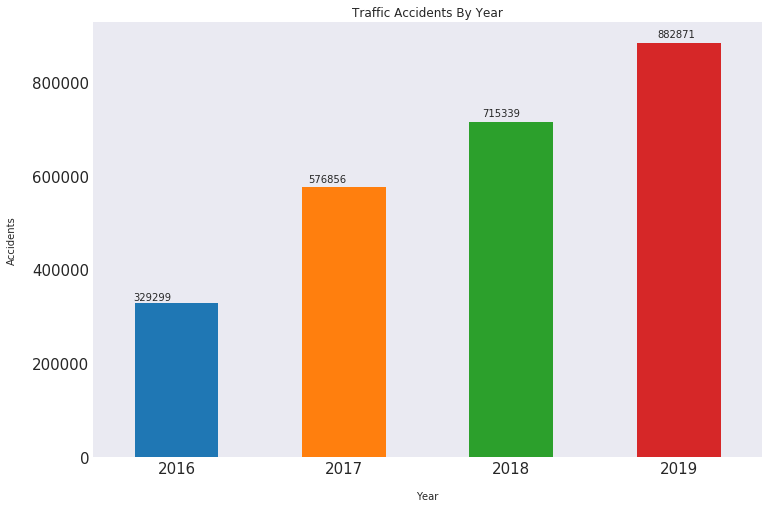

In [363]:
# Bar plots
ax = results_1.toPandas().plot.bar(x="Year", y="Accidents", rot=0, title ="Traffic Accidents By Year",
                                   figsize=(12, 8), legend=False, fontsize=15)
plt.xlabel("Year", labelpad=15)
plt.ylabel("Accidents", labelpad=15)

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.045, p.get_height() * 1.015))

### Q2. Which period of time had the most traffic accidents? Why?

In [364]:
df_time = USaccidentsDf_clean.select("ID", hour(USaccidentsDf_clean["Weather_Timestamp"]).alias('hour'),
                                     dayofweek(USaccidentsDf_clean["Weather_Timestamp"]).alias('day_of_week'))

# Creates a temporary view using the DataFrame
df_time.createOrReplaceTempView("time")

results_2_1 = spark.sql("SELECT t.hour, COUNT(t.ID) AS Accidents\
                         FROM time t\
                         GROUP BY t.hour\
                         ORDER BY Accidents DESC").limit(10)
results_2_1.show()

results_2_2 = spark.sql("SELECT t2.day_of_week, COUNT(t2.ID) AS Accidents\
                         FROM (SELECT t1.ID, t1.day_of_week FROM time t1 WHERE t1.hour IN (7, 8, 16, 17)) AS t2\
                         GROUP BY t2.day_of_week\
                         ORDER BY Accidents DESC")
results_2_2.show()

+----+---------+
|hour|Accidents|
+----+---------+
|   7|   230967|
|   8|   200842|
|  16|   198994|
|  17|   187079|
|  15|   176685|
|   6|   154850|
|  14|   145966|
|   9|   144359|
|  10|   135971|
|  13|   130712|
+----+---------+

+-----------+---------+
|day_of_week|Accidents|
+-----------+---------+
|          3|   162650|
|          4|   158359|
|          5|   153824|
|          6|   145028|
|          2|   145000|
|          7|    28550|
|          1|    24471|
+-----------+---------+



Text(0.5,1,'Traffic Accidents By Time')

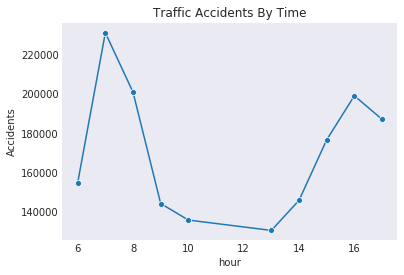

In [365]:
# The traffic accidents by time
ax_2 = results_2_1.toPandas()
sns.lineplot(x = "hour", y = "Accidents", marker = "o", data = ax_2).set_title("Traffic Accidents By Time")

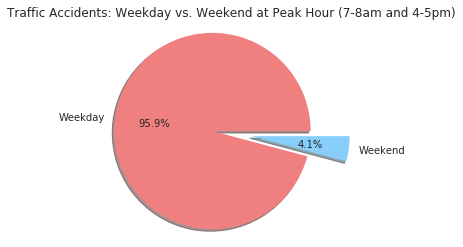

In [366]:
# The comparison of traffic accidents between weekday and weekend
size = [764861, 33021]
labels = ["Weekday", "Weekend"]
colors = ["lightcoral", "lightskyblue"]
explode = (0.4, 0)  # explode 1st slice

plt.pie(size, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=0)
plt.axis("equal")
plt.title("Traffic Accidents: Weekday vs. Weekend at Peak Hour (7-8am and 4-5pm)")
plt.show()

### Q3. Are Visibility, Wind-Speed, and Weather-Condition the reasons of the traffic accidents? Any patterns?

In [367]:
results_3_1 = spark.sql("SELECT ac.Visibility, COUNT(ac.ID) AS Accidents\
                         FROM accidents_clean ac\
                         GROUP BY ac.Visibility\
                         ORDER BY Accidents DESC").limit(10)
results_3_1.show()

results_3_2 = spark.sql("SELECT ac.Wind_Speed, COUNT(ac.ID) AS Accidents\
                         FROM accidents_clean ac\
                         GROUP BY ac.Wind_Speed\
                         ORDER BY Accidents DESC").limit(10)
results_3_2.show()

results_3_3 = spark.sql("SELECT ac.Weather_Condition, COUNT(ac.ID) AS Accidents\
                         FROM accidents_clean ac\
                         GROUP BY ac.Weather_Condition\
                         ORDER BY Accidents DESC").limit(10)
results_3_3.show()

+----------+---------+
|Visibility|Accidents|
+----------+---------+
|      10.0|  2032005|
|       7.0|    71178|
|       9.0|    65312|
|       8.0|    51175|
|       5.0|    46203|
|       6.0|    41718|
|       3.0|    37287|
|       4.0|    37259|
|       2.0|    29350|
|       1.0|    19005|
+----------+---------+

+----------+---------+
|Wind_Speed|Accidents|
+----------+---------+
|       4.6|   215362|
|       5.8|   213697|
|       3.5|   201557|
|       6.9|   199334|
|       8.1|   179731|
|       9.2|   160116|
|       0.0|   135420|
|      10.4|   132087|
|      11.5|   116968|
|      12.7|    86763|
+----------+---------+

+-----------------+---------+
|Weather_Condition|Accidents|
+-----------------+---------+
|            Clear|   614931|
|    Mostly Cloudy|   372256|
|             Fair|   329961|
|         Overcast|   321542|
|    Partly Cloudy|   266127|
| Scattered Clouds|   176044|
|       Light Rain|   128493|
|           Cloudy|   114153|
|       Light Snow|    3

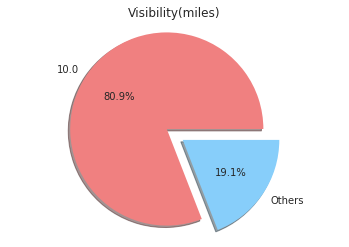

In [368]:
# Data to plot
labels_1 = ["10.0", "Others"]
sizes_1 = [2032005, 479626]
labels_2 = ["Clear", "Cloudy", "Others"]
sizes_2 = [614931, 1250122, 646578]
colors_1 = ['lightcoral', 'lightskyblue']
colors_2 = ['yellowgreen', 'lightcoral', 'lightskyblue']
explode_1 = (0.2, 0)  # explode 1st slice
explode_2 = (0, 0.1, 0)  # explode 1st slice

# Visibility(miles)
plt.pie(sizes_1, explode=explode_1, labels=labels_1, colors=colors_1, autopct='%1.1f%%',
        shadow=True, startangle=0)
plt.axis("equal")
plt.title("Visibility(miles)")
plt.show()

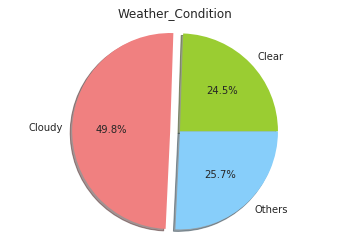

In [369]:
# Weather_Condition
plt.pie(sizes_2,  explode=explode_2, labels=labels_2, colors=colors_2, autopct='%1.1f%%',
        shadow=True, startangle=0)
plt.axis("equal")
plt.title("Weather_Condition")
plt.show()

### Q4. Which state had the most traffic accidents in the past four years? (2016-2019)

In [370]:
results_4_1 = spark.sql("SELECT ac.State, COUNT(ac.ID) AS Accidents\
                         FROM accidents_clean ac\
                         GROUP BY ac.State\
                         ORDER BY Accidents DESC").limit(10)
results_4_2 = spark.sql("SELECT ac.State, COUNT(ac.ID) AS Accidents\
                         FROM accidents_clean ac\
                         WHERE ac.State = 'WA'\
                         GROUP BY ac.State\
                         ORDER BY Accidents DESC")
results_4_1.show()
results_4_2.show()

+-----+---------+
|State|Accidents|
+-----+---------+
|   CA|   528304|
|   TX|   260104|
|   FL|   198820|
|   NY|   121681|
|   SC|   120394|
|   NC|   119279|
|   MI|    82256|
|   IL|    81228|
|   PA|    72462|
|   GA|    69001|
+-----+---------+

+-----+---------+
|State|Accidents|
+-----+---------+
|   WA|    51418|
+-----+---------+



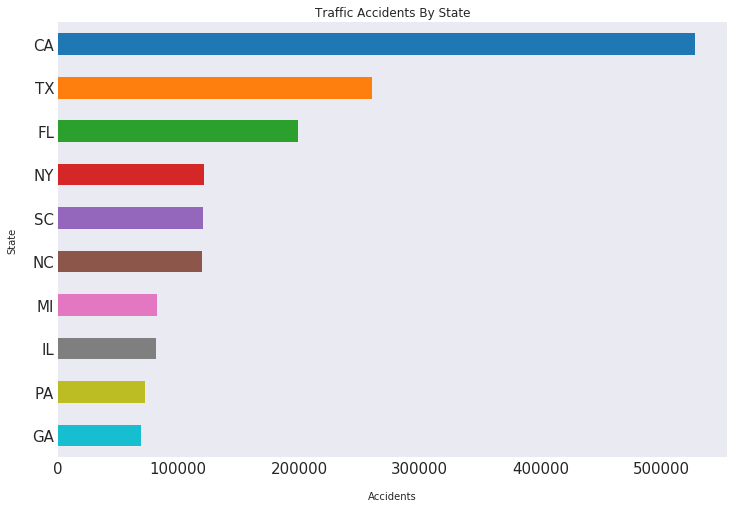

In [371]:
# Horizontal bar plots
ax_4 = results_4_1.toPandas().plot.barh(x="State", y="Accidents", title ="Traffic Accidents By State",
                                        figsize=(12, 8), legend=False, fontsize=15)
plt.xlabel("Accidents", labelpad=15)
plt.ylabel("State", labelpad=15)
ax_4.invert_yaxis()

### Q5. List the Top 10 cities had the most traffic accidents? Any connections to the question 4?

In [372]:
results_5 = spark.sql("SELECT ac.City, ac.State, COUNT(ac.ID) AS Accidents\
                       FROM accidents_clean ac\
                       GROUP BY ac.City, ac.State\
                       ORDER BY Accidents DESC").limit(10)
results_5.show()

+-------------+-----+---------+
|         City|State|Accidents|
+-------------+-----+---------+
|      Houston|   TX|    80099|
|    Charlotte|   NC|    58010|
|       Dallas|   TX|    54183|
|       Austin|   TX|    48954|
|  Los Angeles|   CA|    43655|
|      Raleigh|   NC|    34760|
|      Atlanta|   GA|    31959|
|Oklahoma City|   OK|    29698|
|        Miami|   FL|    28325|
|  Baton Rouge|   LA|    27537|
+-------------+-----+---------+



### Q6. Which states got the improvement of traffic accidents from 2016 to 2019?

In [373]:
state_year = USaccidentsDf_clean.select("ID", "State", "Year")

# Creates a temporary view using the DataFrame
state_year.createOrReplaceTempView("state_year")

results_6 = spark.sql("SELECT sy.Year, sy.State, COUNT(sy.ID) AS Accidents\
                       FROM state_year sy\
                       WHERE sy.Year != 2020\
                       GROUP BY sy.Year, sy.State")

Text(0,0.5,'Accidents')

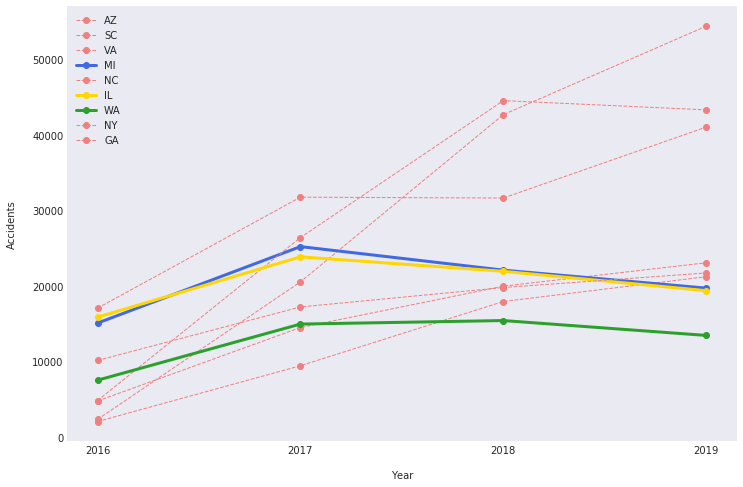

In [374]:
state_list = ["AZ", "SC", "VA", "MI", "NC", "IL", "WA", "NY", "GA"]

df6 = results_6.toPandas()
df6 = df6[df6["State"].isin(state_list)]

df_az = df6[df6["State"] == "AZ"].sort_values(by=['Year'])
df_sc = df6[df6["State"] == "SC"].sort_values(by=['Year'])
df_va = df6[df6["State"] == "VA"].sort_values(by=['Year'])
df_mi = df6[df6["State"] == "MI"].sort_values(by=['Year'])
df_nc = df6[df6["State"] == "NC"].sort_values(by=['Year'])
df_il = df6[df6["State"] == "IL"].sort_values(by=['Year'])
df_wa = df6[df6["State"] == "WA"].sort_values(by=['Year'])
df_ny = df6[df6["State"] == "NY"].sort_values(by=['Year'])
df_ga = df6[df6["State"] == "GA"].sort_values(by=['Year'])

# multiple line plot
plt.figure(figsize=(12,8))

plt.plot( "Year", "Accidents", "--", data=df_az, marker='o', color = "lightcoral", linewidth=1, label="AZ")
plt.plot( "Year", "Accidents", "--", data=df_sc, marker='o', color = "lightcoral", linewidth=1, label="SC")
plt.plot( "Year", "Accidents", "--", data=df_va, marker='o', color = "lightcoral", linewidth=1, label="VA")
plt.plot( "Year", "Accidents", data=df_mi, marker='o', color = "royalblue", linewidth=3, label="MI")
plt.plot( "Year", "Accidents", "--", data=df_nc, marker='o', color = "lightcoral", linewidth=1, label="NC")
plt.plot( "Year", "Accidents", data=df_il, marker='o', color = "gold", linewidth=3, label="IL")
plt.plot( "Year", "Accidents", data=df_wa, marker='o', color = "tab:green", linewidth=3, label="WA")
plt.plot( "Year", "Accidents", "--", data=df_ny, marker='o', color = "lightcoral", linewidth=1, label="NY")
plt.plot( "Year", "Accidents", "--", data=df_ga, marker='o', color = "lightcoral", linewidth=1, label="GA")

plt.legend()
plt.xlabel("Year", labelpad=15)
plt.ylabel("Accidents", labelpad=15)
